In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install pmdarima

In [3]:
cd '/content/gdrive/MyDrive/KHDL/weather-forecast'

/content/gdrive/MyDrive/KHDL/weather-forecast


In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
%matplotlib inline
print(tf.__version__)

1.15.2


In [6]:
file_path = 'main.csv'
df=pd.read_csv(file_path)
df.head(10)

,Ngày,Nhiệt độ tối thiểu hàng ngày,Nhiệt độ tối đa hàng ngày,Mức gió ổn định tối đa,Gió giật tối đa,Tổng lượng mưa hàng ngày,Độ dày của tuyết,Áp suất,Biểu tượng,Mô tả
0,11/1/2015,22°C,25°C,16 Km/h,N/A,17mm,N/A,N/A,,Mưa
1,11/2/2015,22°C,27°C,13 Km/h,N/A,"2,5mm",N/A,N/A,,Mưa
2,11/3/2015,22°C,29°C,15 Km/h,N/A,"2,5mm",N/A,N/A,,Mưa
3,11/4/2015,23°C,30°C,N/A,N/A,"20,3mm",N/A,N/A,,Mưa
4,11/5/2015,23°C,30°C,21 Km/h,N/A,"17,2mm",N/A,N/A,,Mưa
5,11/6/2015,23°C,29°C,11 Km/h,N/A,"9,1mm",N/A,N/A,,Mưa
6,11/7/2015,23°C,29°C,15 Km/h,N/A,"38,1mm",N/A,N/A,,Mưa
7,11/8/2015,24°C,30°C,16 Km/h,N/A,"0,2mm",N/A,N/A,,sự kiện thời tiết không được báo cáo
8,11/9/2015,24°C,32°C,15 Km/h,N/A,0mm,N/A,N/A,,sự kiện thời tiết không được báo cáo
9,11/10/2015,24°C,31°C,16 Km/h,N/A,0mm,N/A,N/A,,sự kiện thời tiết không được báo cáo


In [7]:
data=pd.read_csv('main.csv',usecols=['Ngày','Nhiệt độ tối thiểu hàng ngày','Nhiệt độ tối đa hàng ngày'])
data['Nhiệt độ tối thiểu hàng ngày'] = data['Nhiệt độ tối thiểu hàng ngày'].apply(lambda x : x.split('°C')[0] if '°C' in x else x )
data['Nhiệt độ tối đa hàng ngày'] = data['Nhiệt độ tối đa hàng ngày'].apply(lambda x : x.split('°C')[0] if '°C' in x else x )
data['Nhiệt độ tối thiểu hàng ngày']=data['Nhiệt độ tối thiểu hàng ngày'].astype(float, errors = 'raise')
data['Nhiệt độ tối đa hàng ngày']=data['Nhiệt độ tối đa hàng ngày'].astype(float, errors = 'raise')
data['Nhiệt độ trung bình']=(data['Nhiệt độ tối đa hàng ngày']+data['Nhiệt độ tối thiểu hàng ngày'])/2

In [8]:
data.head(15)

,Ngày,Nhiệt độ tối thiểu hàng ngày,Nhiệt độ tối đa hàng ngày,Nhiệt độ trung bình
0,11/1/2015,22.0,25.0,23.5
1,11/2/2015,22.0,27.0,24.5
2,11/3/2015,22.0,29.0,25.5
3,11/4/2015,23.0,30.0,26.5
4,11/5/2015,23.0,30.0,26.5
5,11/6/2015,23.0,29.0,26.0
6,11/7/2015,23.0,29.0,26.0
7,11/8/2015,24.0,30.0,27.0
8,11/9/2015,24.0,32.0,28.0
9,11/10/2015,24.0,31.0,27.5


Bài toán này em sẽ dùng dữ liệu x_train từ giá trị 1/11/2015 đến ngày 30/4/2021 – 62 days, khi đó. chúng ta sẽ có đến 48 giá trị test để so sánh. Và dữ liệu Y sẽ là giá trị từ 2/11/2015




### MÔ HÌNH RNN

In [9]:
temperature = np.array(data['Nhiệt độ trung bình'])
num_periods = 62                        # Số ngày dự đoán

f_horizon = 1
x_data = temperature[:(len(temperature)-(num_periods*2))]
x_batches = x_data.reshape(-1, num_periods, 1)    #đưa về ma trận 48 cột tương đương 1 ngày

y_data = temperature[1:(len(temperature)-(num_periods*2))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)

In [10]:
def test_data(series, forecast, num):
    testX = temperature[-(num + forecast):][:num].reshape(-1, num_periods, 1)
    testY = temperature[-(num):].reshape(-1, num_periods, 1)
    return testX, testY
X_test, Y_test = test_data(temperature, f_horizon, 62)

In [ ]:
tf.reset_default_graph() # đồ thị mặc định
inputs = 1
rnn_size = 100
output = 1
learning_rate=0.001
tf.disable_v2_behavior()  # tắt tesorflow version 28
dropout_keep_prob = tf.placeholder(tf.float32)  # tạo vùng nhớ float

X = tf.placeholder(tf.float32, [None, num_periods, 1])  # tạo vùng nhớ của mảng chứa num_periods
Y = tf.placeholder(tf.float32, [None, num_periods, 1])

rnn_cells=tf.contrib.rnn.BasicRNNCell(num_units=rnn_size, activation=tf.nn.relu)  # sử dụng mô hình RNN Basic
rnn_output, states = tf.nn.dynamic_rnn(rnn_cells, X, dtype=tf.float32)

output=tf.reshape(rnn_output, [-1, rnn_size])
logit=tf.layers.dense(output, 1, name="softmax")

outputs=tf.reshape(logit, [-1, num_periods, 1])

loss = tf.reduce_sum(tf.square(outputs - Y))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logit, 1), tf.cast(Y, tf.int64)), tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step=optimizer.minimize(loss)

init=tf.global_variables_initializer()

In [12]:
epochs = 500

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

for epoch in range(epochs):
    train_dict = {X: x_batches, Y: y_batches, dropout_keep_prob:0.5}
    sess.run(train_step, feed_dict=train_dict)
y_pred=sess.run(outputs, feed_dict={X: X_test})
save_path = saver.save(sess, "models/weather.ckpt")

In [ ]:
y_pred[0][:-2]

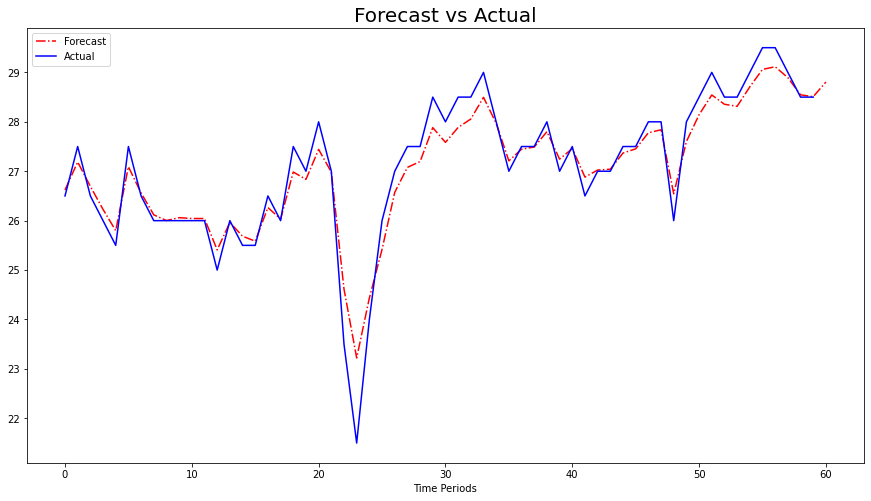

In [14]:
plt.figure(figsize = (15, 8)) 
plt.title("Forecast vs Actual", fontsize=20)
plt.plot(pd.Series(np.ravel(y_pred[0][1:])), "r-.", markersize=10, label="Forecast")
plt.plot(pd.Series(np.ravel(Y_test[0][0:-2])), "b-", markersize=10, label="Actual")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

In [40]:
def _measure_metric(y, yhat):
  e = y-yhat
  mse=np.mean(e**2)
  rmse=np.sqrt(mse)
  mae=np.mean(np.abs(e))
  mape=np.mean(e/y)

  print('Mean Square Error: {}'.format(mse))
  print('Root Mean Square Error: {}'.format(rmse))
  print('Mean Absolute Error: {}'.format(mae))
  print('Mean Absolute Percentage Error: {}'.format(mape))
  return mse, rmse, mae, mape
mse, rmse, mae, mape=_measure_metric(Y_test[0], y_pred)

Mean Square Error: 0.9285390846649652
Root Mean Square Error: 0.9636073290842931
Mean Absolute Error: 0.6981662934826266
Mean Absolute Percentage Error: 0.0019021460357563605


In [41]:
Y_test[0]

array([[26.5],
       [27.5],
       [26.5],
       [26. ],
       [25.5],
       [27.5],
       [26.5],
       [26. ],
       [26. ],
       [26. ],
       [26. ],
       [26. ],
       [25. ],
       [26. ],
       [25.5],
       [25.5],
       [26.5],
       [26. ],
       [27.5],
       [27. ],
       [28. ],
       [27. ],
       [23.5],
       [21.5],
       [24. ],
       [26. ],
       [27. ],
       [27.5],
       [27.5],
       [28.5],
       [28. ],
       [28.5],
       [28.5],
       [29. ],
       [28. ],
       [27. ],
       [27.5],
       [27.5],
       [28. ],
       [27. ],
       [27.5],
       [26.5],
       [27. ],
       [27. ],
       [27.5],
       [27.5],
       [28. ],
       [28. ],
       [26. ],
       [28. ],
       [28.5],
       [29. ],
       [28.5],
       [28.5],
       [29. ],
       [29.5],
       [29.5],
       [29. ],
       [28.5],
       [28.5],
       [29. ],
       [28. ]])

In [17]:
y_pred

array([[[26.44744 ],
        [26.62208 ],
        [27.186506],
        [26.694035],
        [26.22748 ],
        [25.798037],
        [27.091381],
        [26.560904],
        [26.117657],
        [26.001778],
        [26.060614],
        [26.04329 ],
        [26.043398],
        [25.408186],
        [25.962273],
        [25.685984],
        [25.584642],
        [26.265306],
        [26.031893],
        [26.98451 ],
        [26.834929],
        [27.441324],
        [26.982567],
        [24.61611 ],
        [23.221369],
        [24.434946],
        [25.41789 ],
        [26.572031],
        [27.07847 ],
        [27.1952  ],
        [27.882298],
        [27.584333],
        [27.885977],
        [28.056862],
        [28.495398],
        [27.971022],
        [27.209536],
        [27.446215],
        [27.489637],
        [27.800951],
        [27.2445  ],
        [27.457975],
        [26.880861],
        [27.023584],
        [27.041496],
        [27.367992],
        [27.452698],
        [27.7

In [18]:
with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "models/model.ckpt")
    predict=sess.run(outputs, feed_dict={X: X_test})



INFO:tensorflow:Restoring parameters from models/model.ckpt


### MÔ HÌNH ARIMA


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

dataset=pd.read_csv('main.csv',usecols=['Ngày','Nhiệt độ tối thiểu hàng ngày','Nhiệt độ tối đa hàng ngày'])
dataset['Nhiệt độ tối thiểu hàng ngày'] = dataset['Nhiệt độ tối thiểu hàng ngày'].apply(lambda x : x.split('°C')[0] if '°C' in x else x )
dataset['Nhiệt độ tối đa hàng ngày'] = dataset['Nhiệt độ tối đa hàng ngày'].apply(lambda x : x.split('°C')[0] if '°C' in x else x )
dataset['Nhiệt độ tối thiểu hàng ngày']=dataset['Nhiệt độ tối thiểu hàng ngày'].astype(float, errors = 'raise')
dataset['Nhiệt độ tối đa hàng ngày']=dataset['Nhiệt độ tối đa hàng ngày'].astype(float, errors = 'raise')
dataset['Nhiệt độ trung bình']=(dataset['Nhiệt độ tối đa hàng ngày']+dataset['Nhiệt độ tối thiểu hàng ngày'])/2
dataset=dataset.drop(['Nhiệt độ tối thiểu hàng ngày','Nhiệt độ tối đa hàng ngày'], axis=1)
dataset['Ngày']=pd.to_datetime(dataset['Ngày'])
df_season=dataset.set_index('Ngày')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f08ddc61710>],
      dtype=object)

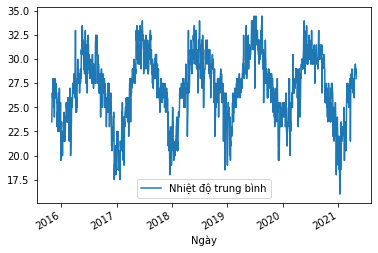

In [20]:
df_season.plot(subplots = True)

In [21]:
df_season

,Nhiệt độ trung bình
Ngày,
2015-11-01,23.5
2015-11-02,24.5
2015-11-03,25.5
2015-11-04,26.5
2015-11-05,26.5
...,...
2021-04-26,29.0
2021-04-27,28.5
2021-04-28,28.5


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f08ec5c0450>],
      dtype=object)

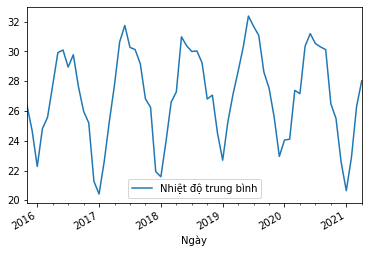

In [22]:
df_season.resample('M').mean().plot(subplots = True)

In [23]:
df_season_monthly = df_season.resample('M').mean()
df_season_monthly.shape

(66, 1)

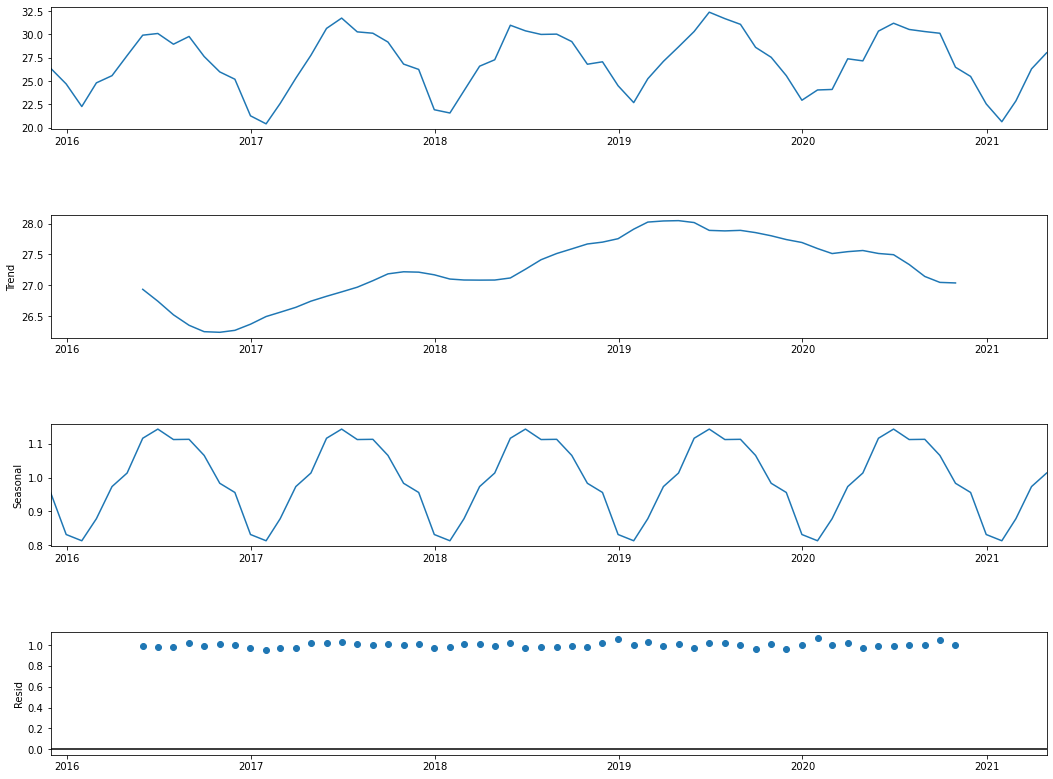

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_season_monthly, model='multiplicative')
fig = result.plot()
fig.set_size_inches(16, 12)

In [25]:
import pmdarima as pm
#by default auto arima uses AIC,the lower aic the model is good
model = pm.auto_arima(df_season_monthly['Nhiệt độ trung bình'],
                      m = 12, seasonal = True,
                      start_p = 0,start_q=0,max_order=4,test='adf',error_action = 'ignore',
                      suppress_warnings =True,
                      stepwise =True,trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=186.025, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=162.901, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=184.037, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=178.263, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=155.457, Time=0.49 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=157.022, Time=0.72 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=156.920, Time=0.38 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=170.391, Time=0.27 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=155.163, Time=0.55 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=160.009, Time=0.24 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=155.555, Time=1.07 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=15

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   66
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 -71.933
Date:                            Sun, 16 May 2021   AIC                            153.866
Time:                                    01:03:24   BIC                            163.811
Sample:                                         0   HQIC                           157.702
                                             - 66                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4190      0.150      2.799      0.005       0.126       0.712
ar.L2          0.2631      0.162      1.629      0.103      -0.053       0.580
ar.S.L12      -0.8410      0.134     -6.261      0.000      -1.104      -0.578
ar.S.L24      -0.4274      0.146     -2.927      0.003      -0.714      -0.141
sigma2         0.6930      0.158      4.385      0.000       0.383       1.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.95   Prob(JB):                         0.96
Heteroskedasticity (H):               1.45   Skew:                             0.04
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
train = df_season_monthly[(df_season_monthly.index.get_level_values(0)>='2015-01-1') & (df_season_monthly.index.get_level_values(0)<='2020-4-30')]
test = df_season_monthly[(df_season_monthly.index.get_level_values(0)>'2020-4-30')]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (54, 1)
test shape:  (12, 1)


In [28]:
model.fit(train['Nhiệt độ trung bình'])
forecast = model.predict(n_periods=12,return_conf_int=True)

In [29]:
forecast_df = pd.DataFrame(forecast[0],index=test.index,columns=['Prediction'])

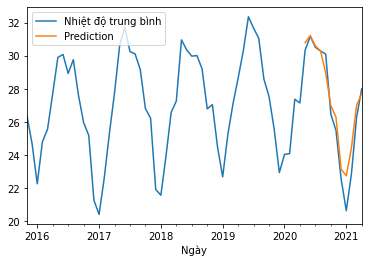

In [30]:
pd.concat([df_season_monthly['Nhiệt độ trung bình'],forecast_df],axis=1).plot()

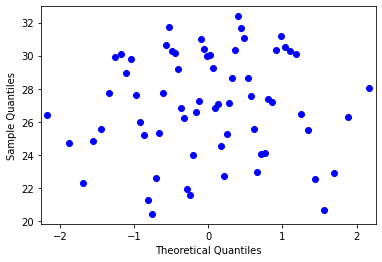

In [31]:
import statsmodels.api as sm
sm.qqplot(df_season_monthly)
plt.show()

In [32]:
dataset.head(5)

,Ngày,Nhiệt độ trung bình
0,2015-11-01,23.5
1,2015-11-02,24.5
2,2015-11-03,25.5
3,2015-11-04,26.5
4,2015-11-05,26.5


In [33]:
import numpy as np
# Tính chuỗi return
r_t = np.log(df_season_monthly['Nhiệt độ trung bình']/df_season_monthly['Nhiệt độ trung bình'].shift(1))
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

Ngày
2015-11-30    0.000933
2015-12-31   -0.066190
2016-01-31   -0.103113
2016-02-29    0.107832
2016-03-31    0.030575
Freq: M, Name: Nhiệt độ trung bình, dtype: float64

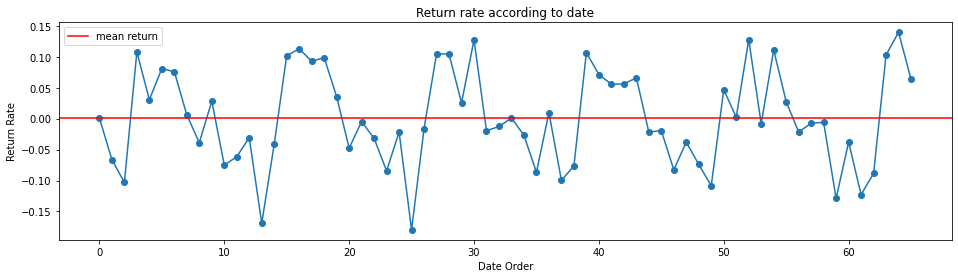

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.plot(np.arange(r_t.shape[0]), r_t, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

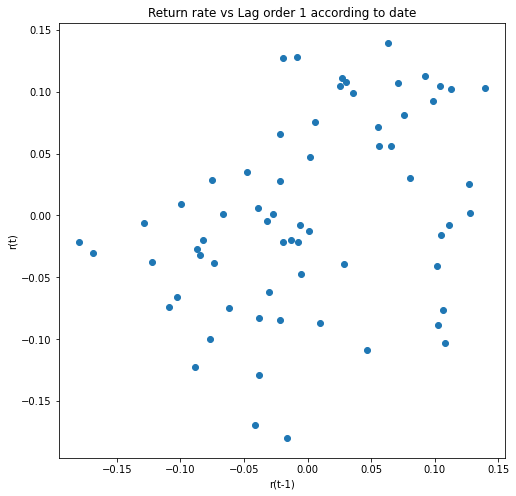

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

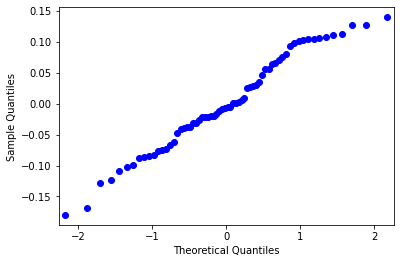

In [36]:
import statsmodels.api as sm
sm.qqplot(r_t)
plt.show()

In [37]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.548287
p-value: 0.000000
Critical Values:
	1%: -3.555
	5%: -2.916
	10%: -2.596


In [38]:
1/(-14-1)

-0.06666666666666667

<Figure size 576x432 with 0 Axes>

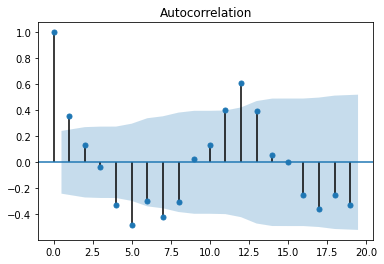

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)